In [93]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from marbleri.models import BaseConvNet
from marbleri.process import get_hwrf_filenames
from marbleri.nwp import HWRFStep, BestTrackNetCDF
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from hagelslag.evaluation.ProbabilityMetrics import DistributedROC, DistributedReliability
from hagelslag.evaluation.MetricPlotter import attributes_diagram
from glob import glob
from os.path import join, exists
import pandas as pd
from matplotlib.colors import LogNorm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import save_model
from marbleri.training import partition_storm_examples
from dask.distributed import LocalCluster, Client
from tqdm import tqdm, trange
%matplotlib inline


In [4]:
!ls /glade/p/ral/allral/dgagne/hfip

processed_data/


In [2]:
print(tf.__version__)

2.0.0


In [2]:
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(tf.config.experimental.list_physical_devices('GPU'))
except AttributeError:
    tf_config = tf.ConfigProto()
    tf_config.gpu_options.allow_growth = True
    K.set_session(tf.Session(config=tf_config))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
class BestTrackNetCDF(object):
    """
    Reads and processes the Best Track NetCDF files.

    """
    def __init__(self,
                 file_path="/glade/p/ral/nsap/rozoff/hfip/besttrack_predictors/",
                 file_start="diag_2015_2017"):
        best_track_files = sorted(glob(join(file_path, file_start + "*.nc")))
        if len(best_track_files) < 2:
            raise FileNotFoundError("Matching best track files not found in " + file_path + "with start " + file_start)
        self.atl_filename = best_track_files[0]
        self.epo_filename = best_track_files[1]
        self.file_path = file_path
        self.bt_ds = dict()
        self.basins = ["l", "e"]
        self.bt_ds["l"] = xr.open_dataset(join(self.file_path, self.atl_filename))
        self.bt_ds["e"] = xr.open_dataset(join(self.file_path, self.epo_filename))
        self.bt_runs = dict()
        self.run_columns = ["DATE", "STNAM", "STNUM", "BASIN"]
        # Some of the variables have (time, nrun) as the dimensions, which causes problems when trying to use
        # the xarray.to_dataframe() function. Changing the dimension from nrun to run fixes the problem.
        for basin in self.basins:
            for variable in self.bt_ds[basin].variables.keys():
                if self.bt_ds[basin][variable].dims == ("time", "nrun"):
                    self.bt_ds[basin][variable] = xr.DataArray(self.bt_ds[basin][variable], dims=("time", "run"))
        for basin in self.bt_ds.keys():
            self.bt_runs[basin] = self.bt_ds[basin][self.run_columns].to_dataframe()
            for col in self.bt_runs[basin].columns:
                self.bt_runs[basin][col] = self.bt_runs[basin][col].str.decode("utf-8").str.strip()

    def get_storm_variables(self, variables, run_date, storm_name, storm_number, basin, forecast_hour):
        b_runs = self.bt_runs[basin]
        run_index = np.where((b_runs["DATE"] == run_date) &
                             (b_runs["STNAM"] == storm_name) &
                             (b_runs["STNUM"] == storm_number))[0]
        fh_index = np.where(self.bt_ds[basin]["TIME"] == forecast_hour)[0]
        
        bt_values = np.zeros((1, len(variables)))
        if len(run_index) > 0 and len(fh_index) > 0: 
            for v, variable in enumerate(variables):
                bt_values[0, v] = self.bt_ds[basin][variable][fh_index[0], run_index[0]].values
        bt_values[np.isnan(bt_values)] = 0
        return bt_values

    def calc_time_differences(self, variables, time_difference_hours):
        step_diff = int(time_difference_hours // 3)
        for basin in self.basins:
            for variable in variables:
                if variable not in list(self.bt_ds[basin].variables.keys()):
                    raise IndexError(variable + " not found in best track data")
                diff_var = np.ones(self.bt_ds[basin][variable].shape, dtype=np.float32) * np.nan
                diff_var[:-step_diff] = self.bt_ds[basin][variable][step_diff:].values - \
                                       self.bt_ds[basin][variable][:-step_diff].values
                diff_var_name = variable + "_dt_{0:02d}".format(time_difference_hours)
                self.bt_ds[basin][diff_var_name] = xr.DataArray(diff_var, dims=("time", "run"), name=diff_var_name)
        return

    def to_dataframe(self, variables, dropna=True):
        basin_dfs = []
        for basin in self.bt_ds.keys():
            print(basin)
            basin_dfs.append(pd.merge(self.bt_runs[basin], self.bt_ds[basin][variables].to_dataframe(), how="right",
                                      left_index=True, right_index=True))
            print(basin_dfs[-1])
            
            if dropna:
                basin_dfs[-1] = basin_dfs[-1].dropna()
        return pd.concat(basin_dfs, ignore_index=True)

    def close(self):
        for basin in self.bt_ds.keys():
            self.bt_ds[basin].close()
            del self.bt_ds[basin]

## Updated ML procedure
Training data: 2015-2017 HWRF

Testing data: 2018 HWRF

Inputs
* beginning and end of intensification period in HWRF
* only beginning
* only end
* differences

Outputs
* HWRF $\frac{dV_{max}}{dt}$ t=24 h
* Best track $\frac{dV_{max}}{dt}$ t=24 h

Models
* Base Convolutional Neural Network
* ResNet
* VAE

In [4]:
bt_nc = BestTrackNetCDF(file_path="/glade/p/ral/allral/dgagne/hfip/besttrack_dv/")
bt_nc_2018 = BestTrackNetCDF(file_path="/glade/p/ral/allral/dgagne/hfip/besttrack_dv/", file_start="diag_2018")

In [5]:
vmax_vars = ["VMAX", "VMAXMPI", "vmax_nhc", "vmax_dshp", "vmax_ivcn", "vmax_lgem", "vmax_hcca", "vmax_bt_new"]
input_vars = ["RMW", "VMAX", "MIN_SLP", "SHR_MAG", "SST", "LAND", "TPW", "TANG850", "VORT850", "DVRG200", "STM_SPD",
             "RHLO", "RHMD", "RHHI", "INST1", "INST2"]
bt_nc.calc_time_differences(input_vars + vmax_vars, 24)
vmax_vars_2018 = ["VMAX", "VMAXMPI", "vmax_bt_new"]
bt_nc_2018.calc_time_differences(input_vars + vmax_vars_2018, 24)
input_vars_dt = [v + "_dt_24" for v in input_vars] 
meta_vars = ["STNAM", "STNUM", "BASIN", "DATE", "TIME"]
dt_df = bt_nc.bt_ds["l"][meta_vars + input_vars_dt + ["vmax_bt_new_dt_24", "vmax_nhc_dt_24", "VMAX_dt_24"]].to_dataframe().dropna()
dt_df_2018 = bt_nc_2018.bt_ds["l"][meta_vars + input_vars_dt + ["vmax_bt_new_dt_24", "VMAX_dt_24"]].to_dataframe().dropna()
for meta_var in meta_vars:
    if meta_var != "TIME":
        dt_df[meta_var] = dt_df[meta_var].str.decode("utf-8").str.strip()
        dt_df_2018[meta_var] = dt_df_2018[meta_var].str.decode("utf-8").str.strip()

In [107]:
dt_df

STNAM STNUM BASIN        DATE  TIME  RMW_dt_24  VMAX_dt_24  \
run  time                                                              
4    0      ana    01     l  2015050800     0 -72.619995         3.0   
     1      ana    01     l  2015050800     3 -75.500000         9.0   
     2      ana    01     l  2015050800     6 -58.119995        16.0   
     3      ana    01     l  2015050800     9 -57.250000         3.0   
     4      ana    01     l  2015050800    12 -34.879997         8.0   
...         ...   ...   ...         ...   ...        ...         ...   
1139 4     rina    19     l  2017110800    12  25.309990         3.0   
1140 0     rina    19     l  2017110806     0  10.750000        -5.0   
     1     rina    19     l  2017110806     3  43.499992        -2.0   
     2     rina    19     l  2017110806     6  42.809998         1.0   
1141 0     rina    19     l  2017110812     0  21.439995       -10.0   

           MIN_SLP_dt_24  SHR_MAG_dt_24   SST_dt_24  ...  VORT850_dt_24  \
run  time                                            ...                  
4    0              -3.0       3.080000   -1.759995  ...     -26.620001   
     1              -2.0       5.730000    0.130005  ...     -22.789999   
     2              -3.0       5.039999   -0.790009  ...     -13.179999   
     3              -1.0       6.920000    0.910004  ...     -14.260000   
     4              -3.0      11.020000    3.450012  ...     -28.450001   
...                  ...            ...         ...  ...            ...   
1139 4              -1.0      13.629999 -121.540001  ...       3.240002   
1140 0               1.0       5.440001 -108.220001  ...      -0.259998   
     1               0.0      10.200001 -122.919998  ...     -18.060001   
     2              -1.0      17.450001 -130.940002  ...     -23.410000   
1141 0               5.0      19.280003 -134.050003  ...     -25.939999   

           DVRG200_dt_24  STM_SPD_dt_24  RHLO_dt_24  RHMD_dt_24  RHHI_dt_24  \
run  time                                                                     
4    0         10.300001       1.000004   19.809998  -25.670013  -28.609985   
     1         -9.160000       0.819740   27.190002   -0.320007   -5.619995   
     2        -16.290001       1.530938   41.640015   11.459991   10.980011   
     3        -16.300001       0.080867   41.300049    5.340027   12.260010   
     4         12.250000       1.435105   44.960022   -6.589996   22.339996   
...                  ...            ...         ...         ...         ...   
1139 4        102.959999      12.196426  -55.909973   49.940002  121.679993   
1140 0         73.349998       9.032827    1.339966   48.950012   59.200012   
     1         82.649994      12.952366  -10.030029   39.520020   89.179993   
     2         98.099998      16.912863  -39.230042   10.080017  106.739990   
1141 0        109.010002      19.409622  -92.769958  -22.440002  119.130005   

           INST1_dt_24  INST2_dt_24  vmax_bt_new_dt_24  vmax_nhc_dt_24  
run  time                                                               
4    0            1.33         0.77               10.0        5.000000  
     1            1.69         0.96               10.0        3.750000  
     2            2.55         1.30               10.0        0.833332  
     3            3.29         1.19               10.0       -2.083332  
     4            3.47         1.36               10.0       -5.000000  
...                ...          ...                ...             ...  
1139 4           -0.69        -0.29               -5.0        0.000000  
1140 0            0.11        -0.13              -10.0        0.000000  
     1           -1.26        -0.60               -7.5        0.000000  
     2           -1.45        -0.73               -5.0        0.000000  
1141 0           -1.49        -1.04               -5.0        0.000000  

[21447 rows x 23 columns]

In [6]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [7]:
get_available_gpus()

['/device:GPU:0']

In [7]:
!echo $CUDA_VISIBLE_DEVICES

1


In [8]:
def get_hwrf_filenames_diff(best_track_df, hwrf_path, diff=24, extension=".nc"):
    """
    Assemble the HWRF file names from the columns of the best track dataframe.

    Args:
        best_track_df: `pandas.DataFrame` containing information about each HWRF time step
        hwrf_path: Path to HWRF files
        extension: type of file containing hwrf data.
    Returns:
        Array of HWRF filenames matching each row in the best track dataframe
    """
    hwrf_filenames_start = []
    hwrf_filenames_end = []
    for i in range(best_track_df.shape[0]):
        storm_name = best_track_df.loc[i, "STNAM"]
        storm_number = int(best_track_df.loc[i, "STNUM"])
        basin = best_track_df.loc[i, "BASIN"]
        run_date = best_track_df.loc[i, "DATE"]
        forecast_hour = int(best_track_df.loc[i, "TIME"])
        fh_end = forecast_hour + diff
        hwrf_filename_start = join(hwrf_path,
                             f"{storm_name}{storm_number:02d}{basin}.{run_date}.f{forecast_hour:03d}" + extension)
        hwrf_filename_end = join(hwrf_path,
                             f"{storm_name}{storm_number:02d}{basin}.{run_date}.f{fh_end:03d}" + extension)
        hwrf_filenames_start.append(hwrf_filename_start)
        hwrf_filenames_end.append(hwrf_filename_end)
    return np.array(hwrf_filenames_start), np.array(hwrf_filenames_end)

In [9]:
hwrf_path = "/glade/p/ral/nsap/rozoff/hfip/reforecast_rotated/"
hwrf_files_start, hwrf_files_end = get_hwrf_filenames_diff(dt_df.reset_index(), hwrf_path)
hwrf_2018_path = "/glade/p/ral/nsap/rozoff/hfip/realtime_rotated/"
hwrf_files_2018_start, hwrf_files_2018_end = get_hwrf_filenames_diff(dt_df_2018.reset_index(), hwrf_2018_path)


In [4]:
['THETA_E_L100',
 'THETA_E_L103',
 'TCOLC_E_L103',
 'U_RAD_L100',
 'U_RAD_L103',
 'V_TAN_L100',
 'V_TAN_L103',
 'SHR_HDG',
 'CENLAT',
 'CENLON',
 'y_0',
 'x_0',
 'lat_0',
 'lon_0',
 'lv_ISBL0']

['THETA_E_L100',
 'THETA_E_L103',
 'TCOLC_E_L103',
 'U_RAD_L100',
 'U_RAD_L103',
 'V_TAN_L100',
 'V_TAN_L103',
 'SHR_HDG',
 'CENLAT',
 'CENLON',
 'y_0',
 'x_0',
 'lat_0',
 'lon_0',
 'lv_ISBL0']

In [10]:
input_var_levels = []
m_vars = ["THETA_E_L100", "U_RAD_L100", "V_TAN_L100"]
s_vars = ["THETA_E_L103", "U_RAD_L103", "V_TAN_L103"]
p_levs = [20000, 50000, 85000]
s_index = 0
for m_var in m_vars:
    for p_lev in p_levs:
            input_var_levels.append((m_var, p_lev))
    input_var_levels.append((s_vars[s_index], None))
    s_index += 1

In [12]:
input_var_levels

[('THETA_E_L100', 20000),
 ('THETA_E_L100', 50000),
 ('THETA_E_L100', 85000),
 ('THETA_E_L103', None),
 ('U_RAD_L100', 20000),
 ('U_RAD_L100', 50000),
 ('U_RAD_L100', 85000),
 ('U_RAD_L103', None),
 ('V_TAN_L100', 20000),
 ('V_TAN_L100', 50000),
 ('V_TAN_L100', 85000),
 ('V_TAN_L103', None)]

In [11]:
hwrf_exists = np.array([exists(hwrf_file) for hwrf_file in hwrf_files_end])

In [13]:
np.any(~hwrf_exists)

False

In [16]:
hwrf_files_se = np.vstack([hwrf_files_start, hwrf_files_end]).T
hwrf_files_se.shape

(21447, 2)

In [15]:
len(hwrf_files_se.tolist())

21447

In [17]:
hwrf_files_2018_se = np.vstack([hwrf_files_2018_start, hwrf_files_2018_end]).T
hwrf_files_2018_se.shape

(7769, 2)

In [13]:
n_workers = 8
cluster = LocalCluster(n_workers=n_workers, threads_per_worker=1, memory_limit=16e9)
client = Client(cluster)

In [26]:
len(client.cluster.workers)

8

In [7]:
def load_data(hwrf_file_list, input_var_levels=None):
    data = []
    step_data = []
    for t, train_file in enumerate(hwrf_file_list):
        step = HWRFStep(train_file)
        for var in input_var_levels:
            step_data.append(step.get_variable(var[0], level=var[1]).values)
        step.close()
        del step
        data.append(np.stack(step_data, axis=-1))
        del step_data[:]
    train_data = np.stack(data, axis=0)
    return train_data

In [15]:
def load_data_diff(hwrf_file_list, input_var_levels=None):
    data = []
    step_data = []
    for t, train_file in enumerate(hwrf_file_list):
        step_start = HWRFStep(train_file[0])
        step_end = HWRFStep(train_file[1])
        for var in input_var_levels:
            step_data.append(step_end.get_variable(var[0], level=var[1]).values - step_start.get_variable(var[0], level=var[1]).values)
        step_end.close()
        step_start.close()
        del step_start, step_end
        data.append(np.stack(step_data, axis=-1))
        del step_data[:]
    train_data = np.stack(data, axis=0)
    return train_data

## Load training data
Use dask to load HWRF reforecast files in parallel.

In [18]:
slice_indices = np.linspace(0, hwrf_files_se.shape[0], n_workers + 1).astype(int)
hwrf_subsets = [hwrf_files_se[slice_index:slice_indices[s + 1]] for s, slice_index in enumerate(slice_indices[:-1])]

In [19]:
out = client.map(load_data_diff, hwrf_subsets, input_var_levels=input_var_levels)

In [22]:
out

[<Future: pending, key: load_data_diff-f4c648be136feb094bc58771f8582370>,
 <Future: pending, key: load_data_diff-49c25d0ab5e03f2c60dc96ef574f3bca>,
 <Future: pending, key: load_data_diff-8f7283e321cd0c651d70dba53f8b735b>,
 <Future: pending, key: load_data_diff-d3c88b1d69603466ee7ebbcde36ff479>,
 <Future: pending, key: load_data_diff-babb154b24e7e96e35a15c553b79dce4>,
 <Future: pending, key: load_data_diff-a7677df8d444185e30a604f2ba4385bc>,
 <Future: pending, key: load_data_diff-6eba359352f2de0f74c35a95c92074a8>,
 <Future: pending, key: load_data_diff-ded612a0dc297f79cab072d7b6fb12bd>]

In [23]:
train_data = np.vstack(client.gather(out))

### Load testing data
Use dask to load testing data in parallel

In [24]:
val_slice_indices = np.linspace(0, hwrf_files_2018_se.shape[0], n_workers + 1).astype(int)
hwrf_val_subsets = [hwrf_files_2018_se[slice_index:val_slice_indices[s + 1]] for s, slice_index in enumerate(val_slice_indices[:-1])]

In [25]:
val_out = client.map(load_data_diff, hwrf_val_subsets, input_var_levels=input_var_levels)

In [29]:
val_out

[<Future: pending, key: load_data_diff-6954878fde3afcc35b851f2f683bc2ee>,
 <Future: pending, key: load_data_diff-5e16dcd14fa4fb67f9cdcb315e723c0e>,
 <Future: pending, key: load_data_diff-12776f4193199c2c98d0d0a747e39a75>,
 <Future: pending, key: load_data_diff-7765a933815d02eefbcf9a6aba3fa24b>,
 <Future: pending, key: load_data_diff-d6963c8aacdcf2cadb1c285c1ea4ed72>,
 <Future: pending, key: load_data_diff-1a3ea1a2f3245c597ff3d43619fa58c3>,
 <Future: pending, key: load_data_diff-a28154da0470ba8d94c0df8caec91f9c>,
 <Future: pending, key: load_data_diff-4fedb4f385c44a30f795a3eb34312cd3>,
 <Future: pending, key: load_data_diff-19f49e5047398ce214f69858af594815>,
 <Future: pending, key: load_data_diff-24ac82cb49505b20985cd51340fd2e24>,
 <Future: pending, key: load_data_diff-9079bb7e294478eea6d5ea5128f28e7e>,
 <Future: pending, key: load_data_diff-e8a614b1464e33163d1864c4be53473a>,
 <Future: pending, key: load_data_diff-86a57433f27d0a80fe2f04553d84e046>,
 <Future: pending, key: load_data_diff

In [26]:
val_data = np.vstack(client.gather(val_out))

In [27]:
norm_train_data = np.zeros(train_data.shape, dtype=np.float32)
train_scaling = np.zeros((train_data.shape[-1], 2), dtype=np.float32)
for c in range(norm_train_data.shape[-1]):
    train_scaling[c, 0] = np.nanmax(train_data[:, :, :, c])
    train_scaling[c, 1] = np.nanmin(train_data[:, :, :, c])
    norm_train_data[:, :, :, c] = (train_data[:, :, :, c] - train_scaling[c, 1]) / (train_scaling[c, 0] - train_scaling[c, 1])
norm_train_data[np.isnan(train_data)] = 0

In [28]:
norm_val_data = np.zeros(val_data.shape, dtype=np.float32)
for c in range(norm_val_data.shape[-1]):
    norm_val_data[:, :, :, c] = (val_data[:, :, :, c] - train_scaling[c, 1]) / (train_scaling[c, 0] - train_scaling[c, 1])
norm_val_data[np.isnan(val_data)] = 0

In [31]:
from tensorflow.keras.layers import Dense, Conv2D, Activation, Input, Flatten, AveragePooling2D, MaxPool2D, LeakyReLU, Dropout, Add
from tensorflow.keras.layers import BatchNormalization, Concatenate, Layer, SpatialDropout2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, binary_crossentropy
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.regularizers import l2

class NormOut(Layer):
    def __init__(self, **kwargs):
        self.mean_dense = Dense(1, **kwargs)
        self.sd_dense = Dense(1, activation=K.exp, **kwargs)
        super(NormOut, self).__init__()

    def call(self, inputs, **kwargs):
        mean_x = self.mean_dense(inputs)
        sd_x = self.sd_dense(inputs)
        return Concatenate()([mean_x, sd_x])

    def compute_output_shape(self, input_shape):
        return input_shape[0], 2


class GaussianMixtureOut(Layer):
    def __init__(self, mixtures=2, **kwargs):
        self.mixtures = mixtures
        self.mean_dense = Dense(self.mixtures, activation="relu", **kwargs)
        self.sd_dense = Dense(self.mixtures, activation=K.exp, **kwargs)
        self.weight_dense = Dense(self.mixtures, activation="softmax", **kwargs)
        super(GaussianMixtureOut, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        mean_x = self.mean_dense(inputs)
        sd_x = self.sd_dense(inputs)
        weights_x = self.weight_dense(inputs)
        return Concatenate()([mean_x, sd_x, weights_x])

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.mixtures * 3


def crps_norm(y_true, y_pred, cdf_points=np.arange(-200, 200.0, 1.0)):
    cdf_points_tensor = K.constant(0.5 * (cdf_points[:-1] + cdf_points[1:]), dtype="float32")
    cdf_point_diffs = K.constant(cdf_points[1:] - cdf_points[:-1], dtype="float32")
    y_pred_cdf = tfd.Normal(loc=y_pred[:, 0:1], scale=y_pred[:, 1:2]).cdf(cdf_points_tensor)
    y_true_cdf = K.cast(y_true <= cdf_points_tensor, "float32")
    cdf_diffs = K.mean((y_pred_cdf - y_true_cdf) ** 2 * cdf_point_diffs, axis=1)
    return K.mean(cdf_diffs)


def crps_mixture(y_true, y_pred, cdf_points=np.arange(0, 200.0, 5.0)):
    cdf_points_tensor = K.constant(0.5 * (cdf_points[:-1] + cdf_points[1:]), dtype="float32")
    cdf_point_diffs = K.constant(cdf_points[1:] - cdf_points[:-1], dtype="float32")
    num_mixtures = y_pred.shape[1] // 3
    weights = [y_pred[:, 2 * num_mixtures + i: 2 * num_mixtures + i + 1] for i in range(num_mixtures)]
    locs = [y_pred[:, i:i+1] for i in range(num_mixtures)]
    scales = [y_pred[:, num_mixtures + i: num_mixtures + i + 1] for i in range(num_mixtures)]
    y_pred_cdf = tf.add_n([weights[i] * tfd.Normal(loc=locs[i], scale=scales[i]).cdf(cdf_points_tensor)
                             for i in range(num_mixtures)])
    y_true_cdf = K.cast(y_true <= cdf_points_tensor, "float32")
    cdf_diffs = K.mean((y_pred_cdf - y_true_cdf) ** 2 * cdf_point_diffs, axis=1)
    return K.mean(cdf_diffs)

losses = {"mse": mean_squared_error,
          "mae": mean_absolute_error,
          "crps_norm": crps_norm,
          "crps_mixture": crps_mixture,
          "binary_crossentropy": binary_crossentropy}

class BaseConvNet(object):
    def __init__(self, min_filters=16, filter_growth_rate=2, filter_width=5, min_data_width=4, pooling_width=2,
                 hidden_activation="relu", output_type="linear",
                 pooling="mean", use_dropout=False, dropout_alpha=0.0, dense_neurons=64,
                 data_format="channels_last", optimizer="adam", loss="mse", leaky_alpha=0.1, metrics=None,
                 learning_rate=0.0001, batch_size=1024, epochs=10, verbose=0, l2_alpha=0, distributed=False):
        self.min_filters = min_filters
        self.filter_width = filter_width
        self.filter_growth_rate = filter_growth_rate
        self.pooling_width = pooling_width
        self.min_data_width = min_data_width
        self.hidden_activation = hidden_activation
        self.output_type = output_type
        self.use_dropout = use_dropout
        self.pooling = pooling
        self.dropout_alpha = dropout_alpha
        self.data_format = data_format
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.loss = loss
        self.dense_neurons = dense_neurons
        self.metrics = metrics
        self.leaky_alpha = leaky_alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None
        self.parallel_model = None
        self.l2_alpha = l2_alpha
        if l2_alpha > 0:
            self.use_l2 = True
        else:
            self.use_l2 = False
        self.verbose = verbose
        self.distributed = distributed

    def build_network(self, conv_input_shape, output_size):
        """
        Create a keras model with the hyperparameters specified in the constructor.

        Args:
            conv_input_shape (tuple of shape [variable, y, x]): The shape of the input data
            output_size: Number of neurons in output layer.
        """
        print("Conv input shape", conv_input_shape)
        if self.use_l2:
            reg = l2(self.l2_alpha)
        else:
            reg = None
        conv_input_layer = Input(shape=conv_input_shape, name="conv_input")
        num_conv_layers = int(np.round((np.log(conv_input_shape[1]) - np.log(self.min_data_width))
                                       / np.log(self.pooling_width)))
        print(num_conv_layers)
        num_filters = self.min_filters
        scn_model = conv_input_layer
        print(reg)
        for c in range(num_conv_layers):
            scn_model = Conv2D(num_filters, (self.filter_width, self.filter_width),
                               data_format=self.data_format, kernel_regularizer=reg,
                               padding="same", name="conv_{0:02d}".format(c))(scn_model)
            if self.hidden_activation == "leaky":
                scn_model = LeakyReLU(self.leaky_alpha, name="hidden_activation_{0:02d}".format(c))(scn_model)
            else:
                scn_model = Activation(self.hidden_activation, name="hidden_activation_{0:02d}".format(c))(scn_model)
            if self.use_dropout:
                scn_model = SpatialDropout2D(rate=self.dropout_alpha)(scn_model)
            num_filters = int(num_filters * self.filter_growth_rate)
            if self.pooling.lower() == "max":
                scn_model = MaxPool2D(pool_size=(self.pooling_width, self.pooling_width),
                                      data_format=self.data_format, name="pooling_{0:02d}".format(c))(scn_model)
            else:
                scn_model = AveragePooling2D(pool_size=(self.pooling_width, self.pooling_width),
                                             data_format=self.data_format, name="pooling_{0:02d}".format(c))(scn_model)
        scn_model = Flatten(name="flatten")(scn_model)
        scn_model = Dense(self.dense_neurons, name="dense_hidden", kernel_regularizer=reg)(scn_model)
        if self.hidden_activation == "leaky":
            scn_model = LeakyReLU(self.leaky_alpha, name="hidden_dense_activation")(scn_model)
        else:
            scn_model = Activation(self.hidden_activation, name="hidden_dense_activation")(scn_model)
        if self.output_type == "linear":
            scn_model = Dense(output_size, kernel_regularizer=reg, name="dense_output")(scn_model)
            scn_model = Activation("linear", name="activation_output")(scn_model)
        elif self.output_type == "sigmoid":
            scn_model = Dense(output_size, kernel_regularizer=reg, name="dense_output")(scn_model)
            scn_model = Activation("sigmoid", name="activation_output")(scn_model)
        elif self.output_type == "gaussian":
            scn_model = NormOut()(scn_model)
        elif "mixture" in self.output_type:
            num_mixtures = int(self.output_type.split("_")[1])
            scn_model = GaussianMixtureOut(mixtures=num_mixtures)(scn_model)
        self.model = Model(conv_input_layer, scn_model)
        print(self.model.summary())

    def compile_model(self):
        """
        Compile the model in tensorflow with the right optimizer and loss function.
        """
        if self.optimizer == "adam":
            opt = Adam(lr=self.learning_rate)
        else:
            opt = SGD(lr=self.learning_rate, momentum=0.99)
        if self.distributed:
            opt = DistributedOptimizer(opt)
        self.model.compile(opt, losses[self.loss], metrics=self.metrics)

    def compile_parallel_model(self, num_gpus):
        self.parallel_model = multi_gpu_model(self.model, num_gpus)
        if self.optimizer == "adam":
            opt = Adam(lr=self.learning_rate)
        else:
            opt = SGD(lr=self.learning_rate, momentum=0.99)
        self.parallel_model.compile(opt, losses[self.loss], metrics=self.metrics)

    @staticmethod
    def get_data_shapes(x, y):
        """
        Extract the input and output data shapes in order to construct the neural network.
        """
        if len(x.shape) != 4:
            raise ValueError("Input data does not have dimensions (examples, y, x, predictor)")
        if len(y.shape) == 1:
            output_size = 1
        else:
            output_size = y.shape[1]
        return x.shape[1:], output_size

    @staticmethod
    def get_generator_data_shapes(data_gen):
        inputs, outputs = data_gen.__getitem__(0)
        if len(outputs.shape) == 1:
            output_size = 1
        else:
            output_size = outputs.shape[1]
        return inputs.shape[1:], output_size

    def fit(self, x, y, val_x=None, val_y=None, build=True, **kwargs):
        """
        Train the neural network.
        """
        if build:
            x_conv_shape, y_size = self.get_data_shapes(x, y)
            self.build_network(x_conv_shape, y_size)
            self.compile_model()
        if val_x is None:
            val_data = None
        else:
            val_data = (val_x, val_y)
        self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose,
                       validation_data=val_data, **kwargs)

    def fit_generator(self, generator, build=True, validation_generator=None, **kwargs):
        if build:
            x_conv_shape, y_size = self.get_generator_data_shapes(generator)
            self.build_network(x_conv_shape, y_size)
            self.compile_model()
        self.model.fit_generator(generator, epochs=self.epochs, verbose=self.verbose,
                                 validation_data=validation_generator, **kwargs)

    def predict(self, x):
        preds = self.model.predict(x, batch_size=self.batch_size)
        if len(preds.shape) == 2:
            if preds.shape[1] == 1:
                preds = preds.ravel()
        return preds
    
    def saliency(self, x, layer_index=-3, ref_activation=10):
        """
        Output the gradient of input field with respect to each neuron in the specified layer.
        Args:
            x:
            layer_index:
            ref_activation: Reference activation value for loss function.
        Returns:
        """
        saliency_values = np.zeros((self.model.layers[layer_index].output.shape[-1],
                                    x.shape[0], x.shape[1],
                                    x.shape[2], x.shape[3]),
                                   dtype=np.float32)
        for s in trange(self.model_.layers[layer_index].output.shape[-1], desc="neurons"):
            sub_model = Model(self.model.input, self.model.layers[layer_index].output[:, s])
            batch_indices = np.append(np.arange(0, x.shape[0], self.batch_size), x.shape[0])
            for b, batch_index in enumerate(tqdm(batch_indices[:-1], desc="batch examples", leave=False)):
                x_case = tf.Variable(x.values[batch_index:batch_indices[b + 1]])
                with tf.GradientTape() as tape:
                    tape.watch(x_case)
                    act_out = sub_model(x_case)
                    loss = (ref_activation - act_out) ** 2
                saliency_values[s, batch_index:batch_indices[b + 1]] = tape.gradient(loss, x_case)
        saliency_da = xr.DataArray(saliency_values, dims=("neuron", "p", "row", "col", "var_name"),
                                   coords=x.coords, name="saliency")
        return saliency_da

In [32]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    bcn = BaseConvNet(min_filters=16, filter_growth_rate=1.5, filter_width=5, pooling_width=2, pooling="max", data_format="channels_last",
                      verbose=1, loss="mae", batch_size=512, epochs=30, use_dropout=False, dropout_alpha=0.1, l2_alpha=0, 
                      min_data_width=4, dense_neurons=64, learning_rate=0.0001, hidden_activation="relu")
    bcn.fit(norm_train_data[:, :, :, :], dt_df["vmax_bt_new_dt_24"].values)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Conv input shape (125, 126, 12)
5
None


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [33]:

bcn_prob = BaseConvNet(min_filters=16, filter_growth_rate=1.5, filter_width=5, pooling_width=2, pooling="max", data_format="channels_last",
                  verbose=1, loss="mse", batch_size=256, epochs=30, use_dropout=False, dropout_alpha=0.1, l2_alpha=0, 
                  min_data_width=4, dense_neurons=32, learning_rate=0.0001, hidden_activation="relu", output_type="sigmoid")
bcn_prob.fit(norm_train_data[:, :, :, :], np.where(dt_df["vmax_bt_new_dt_24"].values >= 30, 1, 0))

Conv input shape (125, 126, 12)
5
None
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_input (InputLayer)      [(None, 125, 126, 12)]    0         
_________________________________________________________________
conv_00 (Conv2D)             (None, 125, 126, 16)      4816      
_________________________________________________________________
hidden_activation_00 (Activa (None, 125, 126, 16)      0         
_________________________________________________________________
pooling_00 (MaxPooling2D)    (None, 62, 63, 16)        0         
_________________________________________________________________
conv_01 (Conv2D)             (None, 62, 63, 24)        9624      
_________________________________________________________________
hidden_activation_01 (Activa (None, 62, 63, 24)        0         
_________________________________________________________________
pooling_01 (MaxPooling

In [187]:
283 / 93

3.043010752688172

In [188]:
319 / 60

5.316666666666666

In [34]:
cnn_prob_preds = bcn_prob.predict(norm_val_data[:, :, :, :]).ravel()

(array([6918.,  334.,  185.,  104.,   83.,   53.,   40.,   19.,   23.,
          10.]),
 array([6.8795101e-14, 9.4171576e-02, 1.8834315e-01, 2.8251472e-01,
        3.7668630e-01, 4.7085789e-01, 5.6502944e-01, 6.5920103e-01,
        7.5337261e-01, 8.4754419e-01, 9.4171578e-01], dtype=float32),
 <a list of 10 Patch objects>)

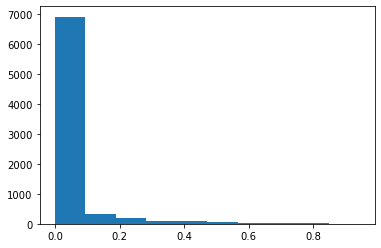

In [35]:
plt.hist(cnn_prob_preds)

In [39]:
cnn_rel = DistributedReliability()
cnn_rel.update(cnn_prob_preds, np.where(dt_df_2018["vmax_bt_new_dt_24"] >= 30, 1, 0))
cnn_rel.brier_skill_score()

0.0059701253672579686

In [40]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition

def attributes_diagram(rel_objs, obj_labels, colors, markers, filename, figsize=(8, 8), xlabel="Forecast Probability",
                       ylabel="Observed Relative Frequency", ticks=np.arange(0, 1.05, 0.05), dpi=300, 
                       title="Attributes Diagram", legend_params=None, inset_params=None,
                       inset_position=(0.12, 0.72, 0.25, 0.25), bootstrap_sets=None, ci=(2.5, 97.5)):
    """
    Plot reliability curves against a 1:1 diagonal to determine if probability forecasts are consistent with their
    observed relative frequency. Also adds gray areas to show where the climatological probabilities lie and what
    areas result in a positive Brier Skill Score.

    Args:
        rel_objs (list): List of DistributedReliability objects.
        obj_labels (list): List of labels describing the forecast model associated with each curve.
        colors (list): List of colors for each line
        markers (list): List of line markers
        filename (str): Where to save the figure.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        ticks (array): Tick value labels for the x and y axes.
        dpi (int): resolution of the saved figure in dots per inch.
        title (str): Title of figure
        legend_params (dict): Keyword arguments for the plot legend.
        inset_params (dict): Keyword arguments for the inset axis.
        inset_position (tuple): Position of the inset axis in normalized axes coordinates (left, bottom, width, height)
        bootstrap_sets (list): A list of arrays of bootstrapped DistributedROC objects. If not None,
            confidence regions will be plotted.
        ci (tuple): tuple of bootstrap confidence interval percentiles
    """
    if legend_params is None:
        legend_params = dict(loc=4, fontsize=10, framealpha=1, frameon=True)
    if inset_params is None:
        inset_params = dict(width="25%", height="25%", loc=2, axes_kwargs=dict(facecolor='white'))
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(ticks, ticks, "k--")
    inset_hist = inset_axes(ax, **inset_params)
    ip = InsetPosition(ax, inset_position)
    inset_hist.set_axes_locator(ip)
    climo = rel_objs[0].climatology()
    no_skill = 0.5 * ticks + 0.5 * climo
    skill_x = [climo, climo, 1, 1, climo, climo, 0, 0, climo]
    skill_y = [climo, 1, 1, no_skill[-1], climo, 0, 0, no_skill[0], climo]
    f = ax.fill(skill_x, skill_y, "0.8")
    f[0].set_zorder(1)
    ax.plot(ticks, np.ones(ticks.shape) * climo, "k--")
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            brel_curves = np.vstack([b_rel.reliability_curve()["Positive_Relative_Freq"].values for b_rel in b_set])
            rel_range = np.nanpercentile(brel_curves, ci, axis=0)
            fb = ax.fill_between(b_rel.thresholds[:-1], rel_range[1], rel_range[0], alpha=0.5, color=colors[b])
            fb.set_zorder(2)
    for r, rel_obj in enumerate(rel_objs):
        rel_curve = rel_obj.reliability_curve()
        ax.plot(rel_curve["Bin_Start"], rel_curve["Positive_Relative_Freq"], color=colors[r],
                marker=markers[r], label=obj_labels[r])
        inset_hist.semilogy(rel_curve["Bin_Start"] * 100, rel_obj.frequencies["Total_Freq"][:-1], color=colors[r],
                            marker=markers[r])
    inset_hist.set_xlabel("Forecast Probability")
    inset_hist.set_ylabel("Frequency")
    ax.annotate("No Skill", (0.6, no_skill[12]), rotation=22.5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(ticks)
    ax.set_xticklabels((ticks * 100).astype(int))
    ax.set_yticks(ticks)
    ax.set_yticklabels((ticks * 100).astype(int))
    ax.legend(**legend_params)
    ax.set_title(title)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.close()

In [42]:
save_model(bcn.model, "hwrf_base_cnn_20200706.h5", save_format="h5")

AttributeError: 'NoneType' object has no attribute '_is_graph_network'

In [90]:
preds = bcn.model.predict(norm_val_data[:, :, :, :], batch_size=2048).ravel()

In [43]:
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", min_samples_leaf=5, n_jobs=32) 
rf.fit(dt_df.loc[:, input_vars_dt], dt_df.loc[:, "vmax_bt_new_dt_24"])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=32, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [44]:
rfp = RandomForestClassifier(n_estimators=100, max_features="sqrt", min_samples_leaf=5, n_jobs=32) 
rfp.fit(dt_df.loc[:, input_vars_dt], np.where(dt_df.loc[:, "vmax_bt_new_dt_24"] >= 30, 1, 0))
rf_prob_preds = rfp.predict_proba(dt_df_2018[input_vars_dt])[:, 1]
rf_rel = DistributedReliability()
rf_rel.update(rf_prob_preds, np.where(dt_df_2018["vmax_bt_new_dt_24"] >= 30, 1, 0))
rf_rel.brier_skill_score()

0.039080497953716244

In [45]:
thresholds = np.arange(0, 1.01, 0.01)
cnn_roc = DistributedROC(thresholds=thresholds)
cnn_roc.update(cnn_prob_preds, np.where(dt_df_2018["vmax_bt_new_dt_24"] >= 30, 1, 0))
rf_roc = DistributedROC(thresholds=thresholds)
rf_roc.update(rf_prob_preds, np.where(dt_df_2018["vmax_bt_new_dt_24"] >= 30, 1, 0))
cnn_roc.auc()

0.7329166759174971

In [46]:
hwrf_roc = DistributedROC(thresholds=np.arange(-60, 60, 1))
hwrf_roc.update(dt_df_2018["VMAX_dt_24"], np.where(dt_df_2018["vmax_bt_new_dt_24"] >= 30, 1, 0))
hwrf_roc.auc()

0.7251419077433154

In [47]:
attributes_diagram([cnn_rel, rf_rel], ["CNN", "RF"], ["r", "c"], ["o", "o"], "hwrf_cnn_rel.pdf")

In [36]:
rf_preds = rf.predict(dt_df_2018[input_vars_dt])

In [91]:
dt_df_2018["HWRF MAE"] = np.abs(dt_df_2018["VMAX_dt_24"] - dt_df_2018["vmax_bt_new_dt_24"])
dt_df_2018["CNN MAE"] = np.abs(preds - dt_df_2018["vmax_bt_new_dt_24"])
dt_df_2018["RF MAE"] = np.abs(rf_preds - dt_df_2018["vmax_bt_new_dt_24"])

In [92]:
bin_start = np.arange(-60, 65, 5)
bin_end = np.arange(-55, 70, 5)
bin_mean = np.zeros((3, bin_start.size))
for b in range(bin_start.size):
    bin_mean[0, b] = np.mean(dt_df_2018.loc[(dt_df_2018["VMAX_dt_24"] >= bin_start[b]) & (dt_df_2018["VMAX_dt_24"] < bin_end[b]), "vmax_bt_new_dt_24"])
    bin_mean[1, b] = np.mean(dt_df_2018.loc[(rf_preds >= bin_start[b]) & (rf_preds < bin_end[b]), "vmax_bt_new_dt_24"])
    bin_mean[2, b] = np.mean(dt_df_2018.loc[(preds >= bin_start[b]) & (preds < bin_end[b]), "vmax_bt_new_dt_24"])

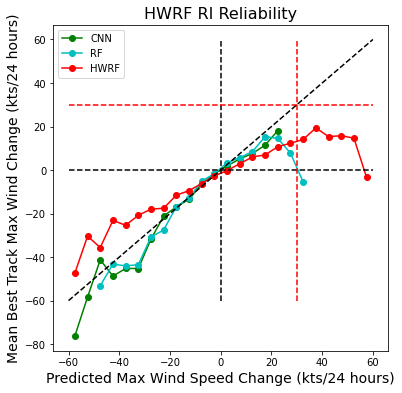

In [93]:
plt.figure(figsize=(6, 6))
plt.plot(bin_start + 2.5, bin_mean[2], 'go-', label="CNN")
plt.plot(bin_start + 2.5, bin_mean[1], 'co-', label="RF")
plt.plot(bin_start + 2.5, bin_mean[0], 'ro-', label="HWRF")

plt.plot(bin_start, np.zeros(bin_start.shape), 'k--')
plt.plot(np.zeros(bin_start.shape), bin_start, 'k--')
plt.plot(np.ones(bin_start.shape) * 30, bin_start, 'r--')
plt.plot(bin_start, np.ones(bin_start.shape) * 30, 'r--')
plt.legend()
plt.plot(bin_start, bin_start, 'k--')
plt.xlabel("Predicted Max Wind Speed Change (kts/24 hours)", fontsize=14)
plt.ylabel("Mean Best Track Max Wind Change (kts/24 hours)", fontsize=14)
plt.title("HWRF RI Reliability", fontsize=16)
plt.savefig("vmax_dt_reliability.png", dpi=200, bbox_inches="tight")

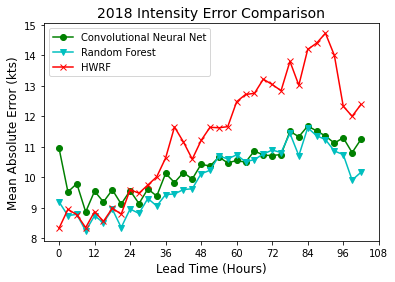

In [183]:
plt.figure(figsize=(6, 4))
plt.plot(dt_df_2018.groupby("TIME")["CNN MAE"].mean(), 'go-', label="Convolutional Neural Net")
plt.plot(dt_df_2018.groupby("TIME")["RF MAE"].mean(), 'cv-', label="Random Forest")

plt.plot(dt_df_2018.groupby("TIME")["HWRF MAE"].mean(), 'rx-', label="HWRF")
plt.xticks(np.arange(0, 120, 12))
plt.legend()
plt.xlabel("Lead Time (Hours)", fontsize=12)
plt.ylabel("Mean Absolute Error (kts)", fontsize=12)
plt.title("2018 Intensity Error Comparison", fontsize=14)
plt.savefig("intensity_error_comp.png", dpi=200)

/glade/u/home/dgagne/miniconda3/envs/goes/lib/python3.7/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


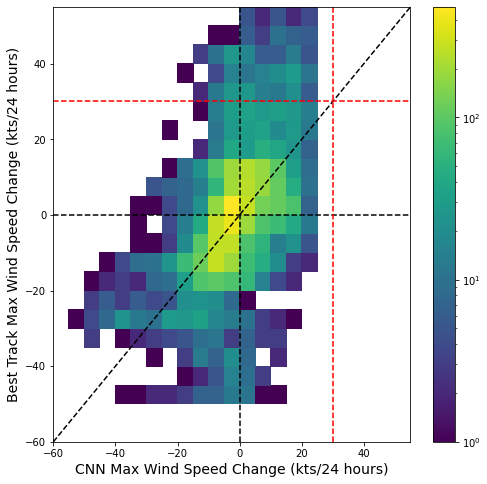

In [95]:
plt.figure(figsize=(8, 8))
_ = plt.hist2d(preds, dt_df_2018.loc[:, "vmax_bt_new_dt_24"], 
           cmin=1, bins=np.arange(-60, 60, 5), norm=LogNorm())
plt.plot(np.arange(-60, 60, 5), np.arange(-60, 60, 5), 'k--')
bins = np.arange(-60, 60, 5)
plt.plot(bins, np.zeros(bins.shape), 'k--')
plt.plot(np.zeros(bins.shape), bins, 'k--')
plt.plot(np.ones(bins.shape) * 30, bins, 'r--')
plt.plot(bins, np.ones(bins.shape) * 30, 'r--')

plt.colorbar()
plt.xlabel("CNN Max Wind Speed Change (kts/24 hours)", fontsize=14)
plt.ylabel("Best Track Max Wind Speed Change (kts/24 hours)", fontsize=14)
plt.savefig("cnn_2d_hist.pdf", dpi=200, bbox_inches="tight")

/glade/u/home/dgagne/miniconda3/envs/goes/lib/python3.7/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


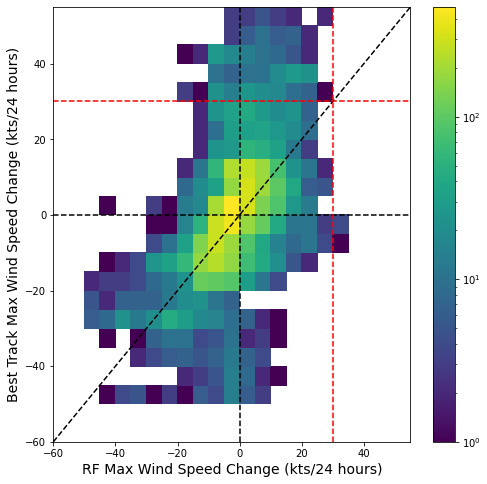

In [96]:
plt.figure(figsize=(8, 8))
_ = plt.hist2d(rf_preds, dt_df_2018.loc[:, "vmax_bt_new_dt_24"], 
           cmin=1, bins=np.arange(-60, 60, 5), norm=LogNorm())
plt.plot(np.arange(-60, 60, 5), np.arange(-60, 60, 5), 'k--')
bins = np.arange(-60, 60, 5)
plt.plot(bins, np.zeros(bins.shape), 'k--')
plt.plot(np.zeros(bins.shape), bins, 'k--')
plt.plot(np.ones(bins.shape) * 30, bins, 'r--')
plt.plot(bins, np.ones(bins.shape) * 30, 'r--')

plt.colorbar()
plt.xlabel("RF Max Wind Speed Change (kts/24 hours)", fontsize=14)
plt.ylabel("Best Track Max Wind Speed Change (kts/24 hours)", fontsize=14)
plt.savefig("rf_2d_hist.pdf", dpi=200, bbox_inches="tight")

In [65]:
train_preds = bcn.model.predict(norm_train_data[:, :, :, :], batch_size=2048).ravel()

In [100]:
bcn.model.layers[-4]

In [101]:
sub_model = Model([bcn.model.input], [bcn.model.layers[-3].output])
sub_out = sub_model.predict(norm_train_data, batch_size=4096)

act_aucs = np.zeros(sub_out.shape[1])
for i in range(sub_out.shape[1]):
    act_aucs[i] = roc_auc_score(dt_df["vmax_bt_new_dt_24"] > 30, sub_out[:, i])

In [113]:
sub_out_2018 = sub_model.predict(norm_val_data, batch_size=4096)

In [111]:
dt_df.shape

(21447, 23)

In [49]:
sub_out_frame = pd.DataFrame(sub_out, columns=[f"Neuron {x:d}" for x in range(sub_out.shape[1])], index=dt_df.index)
sub_out_2018_frame = pd.DataFrame(sub_out_2018, columns=[f"Neuron {x:d}" for x in range(sub_out.shape[1])], index=dt_df_2018.index)

NameError: name 'sub_out' is not defined

In [48]:
combined_train = pd.merge(dt_df, sub_out_frame, left_index=True, right_index=True)
combined_val = pd.merge(dt_df_2018, sub_out_2018_frame, left_index=True, right_index=True)
combined_train.to_csv("/glade/work/dgagne/hwrf_2015-2017_neural_out.csv")
combined_val.to_csv("/glade/work/dgagne/hwrf_2018_neural_out.csv")

NameError: name 'sub_out_frame' is not defined

In [102]:
act_aucs[act_aucs.argsort()[::-1]]

array([0.87018535, 0.84422461, 0.83122949, 0.80932116, 0.80840052,
       0.80063711, 0.78850211, 0.78442325, 0.76571693, 0.74253352,
       0.73394881, 0.72955132, 0.70799113, 0.70576741, 0.70187303,
       0.69227518, 0.69211183, 0.65857707, 0.6581596 , 0.65414431,
       0.63746713, 0.58894235, 0.56833761, 0.56670304, 0.55946183,
       0.52620016, 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.49966074, 0.48839667, 0.48580891,
       0.4578546 , 0.38570729, 0.22004509, 0.21250529, 0.18083856,
       0.17254182, 0.15393055, 0.15346575, 0.1517224 , 0.14654341,
       0.13720423, 0.1345375 , 0.13125345, 0.12992512, 0.12899037,
       0.12842559, 0.12560879, 0.12300555, 0.11949951, 0.11860774,
       0.11853873, 0.11631763, 0.11275022, 0.10405554])

In [71]:
!mkdir composites_new

In [73]:
input_var_levels

[('THETA_E_L100', 20000),
 ('THETA_E_L100', 50000),
 ('THETA_E_L100', 85000),
 ('THETA_E_L103', None),
 ('U_RAD_L100', 20000),
 ('U_RAD_L100', 50000),
 ('U_RAD_L100', 85000),
 ('U_RAD_L103', None),
 ('V_TAN_L100', 20000),
 ('V_TAN_L100', 50000),
 ('V_TAN_L100', 85000),
 ('V_TAN_L103', None)]

In [103]:
! mkdir composites_20200319

In [104]:
for f, f_num in enumerate(act_aucs.argsort()[::-1][:]):
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    plt.subplots_adjust(hspace=0.25)
    ranked_storms = sub_out[:,f_num].argsort()[::-1]
    for a, ax in enumerate(axes.ravel()):
        composite = np.nanmean(train_data[ranked_storms[:30], :, :, a], axis=0)
        m_val = np.nanmax(np.abs(composite))
        ax.contourf(composite, np.linspace(-m_val, m_val, 10), cmap="RdBu_r")
        if input_var_levels[a][1] is None:
            ax.set_title(input_var_levels[a][0][:-5].replace("_", "-") + " "+ 'Surface')
        else:
            ax.set_title(input_var_levels[a][0][:-5].replace("_", "-") + " "+ str(input_var_levels[a][1] // 100) + " hPa")
    fig.suptitle(f"Composite Filter {f_num:03d} AUC={act_aucs[f_num]:0.3f}", fontsize=14, y=0.94)
    plt.savefig(f"composites_20200319/activation_composite_{f:03d}.png", dpi=200, bbox_inches="tight")
    plt.close()

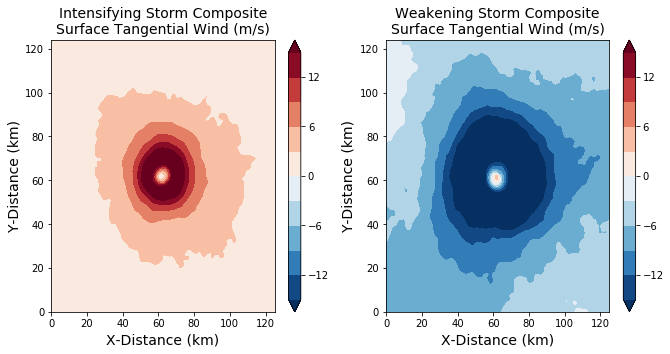

In [83]:
best_worst = act_aucs.argsort()[::-1][[0, -1]]
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
ranked_storms = sub_out[:, best_worst[0]].argsort()[::-1]
v_i = 11
composite = np.nanmean(train_data[ranked_storms[:50], :, :, v_i], axis=0)
m_val = 15
plt.contourf(composite, np.linspace(-m_val, m_val, 11), cmap="RdBu_r", extend="both")
plt.colorbar()
plt.title("Intensifying Storm Composite\nSurface Tangential Wind (m/s)", fontsize=14)
plt.xlabel("X-Distance (km)", fontsize=14)
plt.ylabel("Y-Distance (km)", fontsize=14)

plt.subplot(1, 2, 2)
ranked_storms = sub_out[:, best_worst[1]].argsort()[::-1]
composite = np.nanmean(train_data[ranked_storms[:50], :, :, v_i], axis=0)
plt.contourf(composite, np.linspace(-m_val, m_val, 11), cmap="RdBu_r", extend="both")
plt.title("Weakening Storm Composite\nSurface Tangential Wind (m/s)", fontsize=14)
plt.xlabel("X-Distance (km)", fontsize=14)
plt.ylabel("Y-Distance (km)", fontsize=14)
plt.colorbar()
plt.savefig("storm_composites.png", bbox_inches="tight", dpi=250)

In [82]:
composite.shape

(125, 126)

In [83]:
composite.shape[0] / 2

62.5

(array([1.0097e+04, 5.8090e+03, 2.9570e+03, 1.4380e+03, 6.5500e+02,
        3.1100e+02, 1.1100e+02, 4.3000e+01, 1.8000e+01, 8.0000e+00]),
 array([0.        , 0.39207458, 0.78414917, 1.1762238 , 1.5682983 ,
        1.9603729 , 2.3524475 , 2.744522  , 3.1365967 , 3.5286713 ,
        3.9207458 ], dtype=float32),
 <a list of 10 Patch objects>)

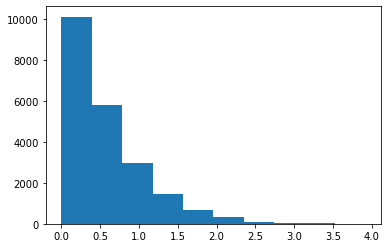

In [96]:
plt.hist(sub_out[:, 0, 0, f_num])

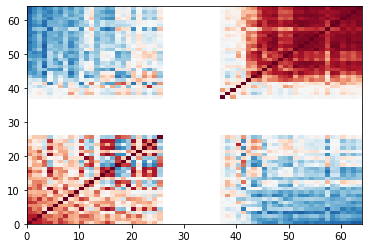

In [126]:
plt.pcolormesh(np.corrcoef(sub_out.T[act_aucs.argsort()[::-1]]), vmin=-1, vmax=1, cmap="RdBu_r")

NameError: name 'combined_train' is not defined

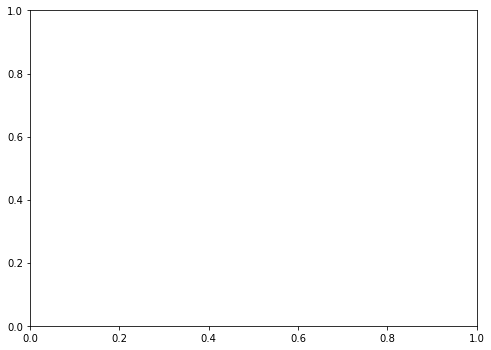

In [41]:
fig, ax1=  plt.subplots(figsize=(8, 6))
plt.subplots_adjust(bottom=0.15)
p1 = ax1.plot(combined_train[combined_train["STNAM"] == "harvey"]["TIME"].unstack().loc[474], 
         combined_train[combined_train["STNAM"] == "harvey"]["Neuron 14"].unstack().loc[474], color="r", label="Strengthening Neuron")
p2 = ax1.plot(combined_train[combined_train["STNAM"] == "harvey"]["TIME"].unstack().loc[474],
         combined_train[combined_train["STNAM"] == "harvey"]["Neuron 59"].unstack().loc[474], color="b", label="Weakening Neuron")
ax1.set_xticks(np.arange(0, 100, 6))
ax1.set_ylabel("Neuron Value", fontsize=14)
ax1.set_xlabel("Forecast Hour", fontsize=14)
ax1.set_title("Hurricane Harvey Neuron Forecast", fontsize=16)
ax2 = ax1.twinx()
p3 = ax2.plot(combined_train[combined_train["STNAM"] == "harvey"]["TIME"].unstack().loc[474],
    combined_train[combined_train["STNAM"] == "harvey"]['vmax_bt_new_dt_24'].unstack().loc[474],color='k', label="Wind Speed Change")
ax2.set_ylabel("Change in Wind Speed (kts)", fontsize=14)
fig.legend([p1[0], p2[0], p3[0]], ["Intensify Neuron", "Weaken Neuron", "Wind Speed Change"], loc="lower center", ncol=3)
plt.savefig("harvey_neuron_example.pdf", bbox_inches="tight")

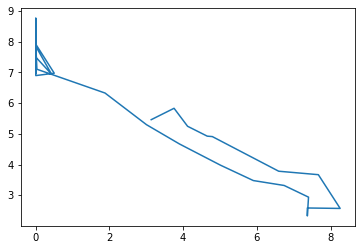

In [215]:
plt.plot(combined_train[combined_train["STNAM"] == "harvey"]["Neuron 59"].unstack().loc[474], combined_train[combined_train["STNAM"] == "harvey"]["Neuron 14"].unstack().loc[474])

In [58]:
dt_df_2018.loc[dt_df_2018["STNAM"] == "michael"]["DATE"].unique()

array(['2018100718', '2018100800', '2018100806', '2018100812',
       '2018100818', '2018100900', '2018100906', '2018100912',
       '2018100918', '2018101000', '2018101006', '2018101012',
       '2018101018', '2018101100', '2018101106', '2018101112'],
      dtype=object)

In [122]:
case_run = val_data[(dt_df_2018["STNAM"] == "michael") & (dt_df_2018["DATE"] == "2018100718")]

In [90]:
case_norm = norm_val_data[(dt_df_2018["STNAM"] == "michael") & (dt_df_2018["DATE"] == "2018100718")]

In [99]:
def saliency(self, x, layer_index=-3, ref_activation=10):
        """
        Output the gradient of input field with respect to each neuron in the specified layer.
        Args:
            x:
            layer_index:
            ref_activation: Reference activation value for loss function.
        Returns:
        """
        saliency_values = np.zeros((self.model.layers[layer_index].output.shape[-1],
                                    x.shape[0], x.shape[1],
                                    x.shape[2], x.shape[3]),
                                   dtype=np.float32)
        for s in trange(self.model.layers[layer_index].output.shape[-1], desc="neurons"):
            sub_model = Model(self.model.input, self.model.layers[layer_index].output[:, s])
            batch_indices = np.append(np.arange(0, x.shape[0], self.batch_size), x.shape[0])
            for b, batch_index in enumerate(tqdm(batch_indices[:-1], desc="batch examples", leave=False)):
                x_case = tf.Variable(x[batch_index:batch_indices[b + 1]])
                with tf.GradientTape() as tape:
                    tape.watch(x_case)
                    act_out = sub_model(x_case)
                    loss = (ref_activation - act_out) ** 2
                saliency_values[s, batch_index:batch_indices[b + 1]] = tape.gradient(loss, x_case)
        return saliency_values

In [108]:
bcn_prob.model.layers[-1]

In [109]:
sal_case = saliency(bcn_prob, case_norm, layer_index=-1, ref_activation=1)

neurons: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s][A


In [103]:
sal_case.shape

(1, 31, 125, 126, 12)

In [106]:
case_run.shape

(31, 125, 126)

In [113]:
from scipy.ndimage import gaussian_filter

In [142]:
case_df = dt_df_2018.loc[(dt_df_2018["STNAM"] == "michael") & (dt_df_2018["DATE"] == "2018100718")]

In [170]:
sal_case.shape

(1, 31, 125, 126, 12)

In [156]:
case_df["DATE"][1]

'2018100718'

In [180]:
sal_time.max()

0.00021889772

In [187]:
for t in range(case_df.shape[0]):
    print(t)
    plt.figure(figsize=(13, 10))
    plt.pcolormesh(case_run[t, ::-1, :, -2] * 2.23694, vmin=-80, vmax=80, cmap="RdBu_r")
    cb = plt.colorbar()
    sal_time = gaussian_filter(sal_case[0, t, ::-1, :, -2], 2)
    sal_time_scaled = sal_time / (sal_time.max() - sal_time.min())
    print(sal_time_scaled.min(), sal_time_scaled.max())
    cb.set_label(label="24-Hour Change in Wind Speed (mph)",fontsize=16)
    cont = plt.contour(sal_time_scaled, [-1, -0.5, -0.25, 0.25, 0.5, 1], vmin=-0.8, vmax=0.8, linewidths=3, cmap="PuOr", extend="both")
    plt.axis('off')
    valid_time = pd.Timestamp(case_df["DATE"][t] + "00") + pd.Timedelta(hours=case_df["TIME"][t])
    plt.title("Deep Learning Vision of Hurricane Michael " + valid_time.strftime("%Y-%m-%d %H:%M"), fontsize=16)
    plt.savefig(f"saliency/michael_saliency_{t:02d}.png", dpi=150, bbox_inches="tight")
    plt.close()

0
-0.3303518 0.66964823
1
-0.44890586 0.5510941
2
-0.48131424 0.51868576
3
-0.28734082 0.7126591
4
-0.7475242 0.2524758
5
-0.64945185 0.35054812
6
-0.4609484 0.53905165
7
-0.47189614 0.5281039
8
-0.6775937 0.32240632
9
-0.4788009 0.5211991
10
-0.3550796 0.6449204
11
-0.5108569 0.48914313
12
-0.44257686 0.5574231
13
-0.37478325 0.6252167
14
-0.63715476 0.36284518
15
-0.7625457 0.23745434
16
-0.7984066 0.2015934
17
-0.6062345 0.3937655
18
-0.409958 0.590042
19
-0.43698466 0.56301534
20
-0.25095004 0.74904996
21
-0.47055018 0.5294498
22
-0.62802845 0.3719716
23
-0.54416704 0.455833
24
-0.6372054 0.36279464
25
-0.50018966 0.49981037
26
-0.6329978 0.36700222
27
-0.6327794 0.36722058
28
-0.7040209 0.29597905
29
-0.69466347 0.30533653
30
-0.52350354 0.47649646


In [142]:
combined_train.columns

Index(['STNAM', 'STNUM', 'BASIN', 'DATE', 'TIME', 'RMW_dt_24', 'VMAX_dt_24',
       'MIN_SLP_dt_24', 'SHR_MAG_dt_24', 'SST_dt_24', 'LAND_dt_24',
       'TPW_dt_24', 'TANG850_dt_24', 'VORT850_dt_24', 'DVRG200_dt_24',
       'STM_SPD_dt_24', 'RHLO_dt_24', 'RHMD_dt_24', 'RHHI_dt_24',
       'INST1_dt_24', 'INST2_dt_24', 'vmax_bt_new_dt_24', 'vmax_nhc_dt_24',
       'Neuron 0', 'Neuron 1', 'Neuron 2', 'Neuron 3', 'Neuron 4', 'Neuron 5',
       'Neuron 6', 'Neuron 7', 'Neuron 8', 'Neuron 9', 'Neuron 10',
       'Neuron 11', 'Neuron 12', 'Neuron 13', 'Neuron 14', 'Neuron 15',
       'Neuron 16', 'Neuron 17', 'Neuron 18', 'Neuron 19', 'Neuron 20',
       'Neuron 21', 'Neuron 22', 'Neuron 23', 'Neuron 24', 'Neuron 25',
       'Neuron 26', 'Neuron 27', 'Neuron 28', 'Neuron 29', 'Neuron 30',
       'Neuron 31', 'Neuron 32', 'Neuron 33', 'Neuron 34', 'Neuron 35',
       'Neuron 36', 'Neuron 37', 'Neuron 38', 'Neuron 39', 'Neuron 40',
       'Neuron 41', 'Neuron 42', 'Neuron 43', 'Neuron 44', 'Neu

In [170]:
np.unique(np.array(combined_train[combined_train["STNAM"] == "harvey"].index.values.tolist())[:, 0])

array([452, 453, 454, 455, 456, 457, 458, 459, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504])

In [213]:
combined_train["STNAM"].unique().size

53

In [214]:
combined_val["STNAM"].unique().size

18